In [1]:
import os, yaml, torch, GPUtil, cv2
from ultralytics import YOLO

# ─── CONFIG ───
ORIG_YAML   = "data.yaml"          # existing YAML (relative paths)
FIXED_YAML  = "data_abs.yaml"      # will be written with abs paths
WEIGHTS     = "yolov11n.pt"        # ▼ YOLOv11-nano (good for small sets)
RUNS_DIR    = "yolov11_runs"
DEVICE_ID   = 0
IMGSZ       = 640

# fine-tune hyper-params (see analysis)
EPOCHS      = 100                  # ▼ longer, but…
PATIENCE    = 20                   # ▼ …early-stop after 20 no-gain epochs
FREEZE      = 5                    # ▼ freeze backbone first 5 epochs
LR0         = 0.01                 # initial LR

# decide batch size from free VRAM (simple heuristic)
gpu        = GPUtil.getGPUs()[DEVICE_ID]
BATCH      = 16 if gpu.memoryFree > 6_000 else 8   # ▼

# ─── 1) PROJECT ROOT FROM NOTEBOOK LOCATION ───
root = os.path.dirname(os.path.abspath(ORIG_YAML))
os.chdir(root)

# ─── 2) ABSOLUTE-PATH YAML (unchanged) ───
with open(ORIG_YAML) as f:
    y = yaml.safe_load(f)
nc, names = y.get("nc"), y.get("names")
if nc is None or names is None:
    raise ValueError("data.yaml must contain 'nc' and 'names'")

paths = {
    "train": os.path.join(root, "train", "images"),
    "val":   os.path.join(root, "valid", "images"),
    "test":  os.path.join(root, "test",  "images"),
}
for k, p in paths.items():
    if not os.path.isdir(p):
        raise FileNotFoundError(f"Expected {k}-images at:\n  {p}")

with open(FIXED_YAML, "w") as f:
    yaml.safe_dump({**paths, "nc": nc, "names": names}, f)
print("Wrote absolute-path dataset to", FIXED_YAML)


Wrote absolute-path dataset to data_abs.yaml


In [ ]:
# ─── WEIGHTS DOWNLOAD / GPU CHECK (unchanged) ───
from ultralytics import YOLO
import urllib.request, pathlib, os, torch, sys

WEIGHTS = "yolo11n"            # implicit .pt

def safe_load(weights: str, fallback_url: str):
    try:
        return YOLO(weights)   # ① works if Ultralytics ≥8.3 or file exists
    except (FileNotFoundError, RuntimeError):
        fn = pathlib.Path(weights if weights.endswith(".pt") else f"{weights}.pt").name
        print(f"[INFO] '{fn}' missing – downloading from {fallback_url} …", file=sys.stderr)
        urllib.request.urlretrieve(fallback_url, fn)   # ② one-off download
        return YOLO(fn)        # ③ load again from disk

model = safe_load(
    WEIGHTS,
    "https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11n.pt",
)

print("CUDA devices:", torch.cuda.device_count(), "| model loaded OK!")

print("CUDA:", torch.cuda.is_available(), "| devices:", torch.cuda.device_count())
if not torch.cuda.is_available():
    raise RuntimeError("CUDA GPU not found.")

# ───  TRAIN  ───
model = YOLO(WEIGHTS)

results = model.train(
    data        = FIXED_YAML,
    epochs      = EPOCHS,
    imgsz       = IMGSZ,
    batch       = BATCH,
    device      = DEVICE_ID,
    project     = RUNS_DIR,
    name        = "bottle_defects",
    lr0         = LR0,
    warmup_epochs = 3,
    patience    = PATIENCE,        # ↢ Ultralytics built-in early-stop
    freeze      = FREEZE,          # freeze backbone then unfreeze
    cos_lr      = True,            # cosine decay
    optimizer   = "SGD",
    amp         = True,            # FP16
    # ↘︎ light augmentations suited to large, centred objects
    mosaic      = 0.30,
    mixup       = 0.20,
    hsv_h       = 0.015, hsv_s = 0.70, hsv_v = 0.40,
    scale       = 0.50, translate = 0.10,
    shear       = 3.0,  perspective = 0.0,
    flipud      = 0.0, fliplr = 0.5,
    close_mosaic = 15              # stop mosaics after epoch 15
)


100%|██████████| 5.35M/5.35M [00:00<00:00, 22.5MB/s]


CUDA devices: 1 | model loaded OK!
CUDA: True | devices: 1
New https://pypi.org/project/ultralytics/8.3.140 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.139  Python-3.10.11 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 5090, 32607MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=15, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=data_abs.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=5, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.3, multi_scale=False, name=

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\cuda\__init__.py:235: UserWarning: 
NVIDIA GeForce RTX 5090 with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


YOLO11n summary: 181 layers, 2,590,230 parameters, 2,590,214 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.weight'
Freezing layer 'model.2.cv1.bn.bias'
Freezing layer 'model.2.cv2.conv.weight'
Freezing layer 'model.2.cv2.bn.weight'
Freezing layer 'model.2.cv2.bn.bias'
Freezing layer 'model.2.m.0.cv1.conv.weight'
Freezing layer 'model.2.m.0.cv1.bn.weight'
Freezing layer 'model.2.m.0.cv1.bn.bias'
Freezing layer 'model.2.m.0.cv2.conv.weight'
Freezing layer 'model.2.m.0.cv2.bn.weight'
Freezing layer 'model.2.m.0.cv2.bn.bias'
Freezing layer 'model.3.conv.weight'
Freezing layer 'model.3.bn.weight'
Freezing layer 'model.3.bn.bias'
Freezing layer 'model.4.cv1.conv.weight'
Freezing layer 'mo

train: Scanning C:\Users\USER\Documents\ClientProject\latest bottle dataset\train\labels... 140 images, 0 backgrounds, 0 corrupt: 100%|██████████| 140/140 [00:00<00:00, 1132.50it/s]

train: New cache created: C:\Users\USER\Documents\ClientProject\latest bottle dataset\train\labels.cache



c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.10.0 ms, read: 5.82.0 MB/s, size: 27.9 KB)


val: Scanning C:\Users\USER\Documents\ClientProject\latest bottle dataset\valid\labels... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<00:00, 713.40it/s]

val: New cache created: C:\Users\USER\Documents\ClientProject\latest bottle dataset\valid\labels.cache


Plotting labels to yolov11_runs\bottle_defects\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov11_runs\bottle_defects
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.23G      1.328      3.325      1.788         28        640: 100%|██████████| 9/9 [03:07<00:00, 20.88s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         30         30    0.00335          1     0.0233    0.00729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      2/100      5.24G     0.9182      3.323       1.52         19        640: 100%|██████████| 9/9 [00:01<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

                   all         30         30    0.00323      0.967     0.0691      0.019

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      3/100      5.26G     0.8231      3.067      1.404         22        640: 100%|██████████| 9/9 [00:01<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

                   all         30         30    0.00345          1      0.397      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      4/100      5.27G      0.749       2.83      1.353         24        640: 100%|██████████| 9/9 [00:01<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

                   all         30         30    0.00354          1      0.594      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      5/100      5.28G     0.7678      2.476      1.323         20        640: 100%|██████████| 9/9 [00:01<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


                   all         30         30    0.00357          1      0.635      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.29G     0.7627      2.189      1.324         18        640: 100%|██████████| 9/9 [00:01<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         30         30    0.00343          1      0.567      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       5.3G       0.79      1.952      1.311         21        640: 100%|██████████| 9/9 [00:01<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]

                   all         30         30    0.00336          1      0.482      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.31G     0.7035      1.749      1.272         20        640: 100%|██████████| 9/9 [00:01<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all         30         30    0.00337          1      0.682      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.32G     0.8372      1.619      1.375         14        640: 100%|██████████| 9/9 [00:01<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

                   all         30         30      0.685      0.272      0.634       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.33G     0.8786      1.619      1.403         26        640: 100%|██████████| 9/9 [00:01<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all         30         30       0.68      0.596      0.724      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     11/100      5.34G     0.8573      1.589      1.363         17        640: 100%|██████████| 9/9 [00:01<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


                   all         30         30      0.589      0.247      0.507      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.35G     0.8914      1.551      1.389         31        640: 100%|██████████| 9/9 [00:01<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         30         30      0.755      0.567      0.708      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.36G     0.8548      1.588      1.364         15        640: 100%|██████████| 9/9 [00:01<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]

                   all         30         30      0.764      0.517      0.505      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.37G     0.8499      1.502      1.364         17        640: 100%|██████████| 9/9 [00:01<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]

                   all         30         30      0.559      0.818      0.813      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.38G     0.9006      1.461      1.404         20        640: 100%|██████████| 9/9 [00:01<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

                   all         30         30          1      0.914      0.958      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.39G     0.8199      1.424      1.359         23        640: 100%|██████████| 9/9 [00:01<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


                   all         30         30      0.887        0.9       0.92      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       5.4G      0.936      1.424      1.446         20        640: 100%|██████████| 9/9 [00:01<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

                   all         30         30      0.818      0.825      0.841      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.41G     0.8955       1.38       1.43         20        640: 100%|██████████| 9/9 [00:01<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         30         30      0.884      0.851       0.96      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.42G     0.8701      1.268      1.363         27        640: 100%|██████████| 9/9 [00:01<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

                   all         30         30       0.42      0.767       0.56      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.43G     0.7944      1.188      1.302         21        640: 100%|██████████| 9/9 [00:01<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

                   all         30         30       0.76      0.927      0.906      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.43G     0.8898      1.215      1.353         17        640: 100%|██████████| 9/9 [00:01<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

                   all         30         30      0.668      0.896      0.841      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     22/100      5.45G     0.8761       1.16      1.324         16        640: 100%|██████████| 9/9 [00:01<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         30         30       0.87        0.8      0.868      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.46G     0.8586       1.22      1.348         23        640: 100%|██████████| 9/9 [00:01<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         30         30      0.893      0.816      0.907      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.47G     0.8287      1.206      1.326         20        640: 100%|██████████| 9/9 [00:01<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         30         30      0.791      0.967      0.941      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.48G     0.8422      1.125      1.356         27        640: 100%|██████████| 9/9 [00:01<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]

                   all         30         30      0.829      0.961      0.939      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.49G     0.8632      1.131       1.32         17        640: 100%|██████████| 9/9 [00:01<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

                   all         30         30      0.698      0.868      0.868      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       5.5G     0.8453      1.129      1.331         23        640: 100%|██████████| 9/9 [00:01<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

                   all         30         30      0.772        0.9      0.906      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     28/100      5.51G     0.8529      1.164      1.345         18        640: 100%|██████████| 9/9 [00:01<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]

                   all         30         30       0.86      0.962      0.934      0.825

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     29/100      5.52G     0.9237      1.128      1.383         18        640: 100%|██████████| 9/9 [00:01<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]

                   all         30         30      0.859        0.9      0.926      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.53G      0.814      1.077      1.265         24        640: 100%|██████████| 9/9 [00:01<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

                   all         30         30      0.859      0.833      0.943      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.54G     0.8795      1.076      1.334         21        640: 100%|██████████| 9/9 [00:01<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]

                   all         30         30      0.998      0.979      0.995      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.54G     0.7864      1.107      1.291         20        640: 100%|██████████| 9/9 [00:01<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

                   all         30         30      0.897      0.867      0.958      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.55G     0.7959     0.9816      1.269         24        640: 100%|██████████| 9/9 [00:01<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


                   all         30         30      0.968      0.913      0.981       0.81

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.56G     0.7575     0.9559      1.253         20        640: 100%|██████████| 9/9 [00:01<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         30         30       0.93          1      0.991      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.57G     0.7827      1.003      1.283         14        640: 100%|██████████| 9/9 [00:01<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]

                   all         30         30      0.876      0.972      0.962      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.58G     0.7886     0.9684      1.268         18        640: 100%|██████████| 9/9 [00:01<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]

                   all         30         30      0.984      0.991      0.995       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.59G     0.7281     0.9487      1.218         29        640: 100%|██████████| 9/9 [00:01<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         30         30      0.991          1      0.995      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       5.6G     0.7103     0.8761      1.216         17        640: 100%|██████████| 9/9 [00:01<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]

                   all         30         30      0.995      0.996      0.995      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.61G     0.7461     0.8441      1.269         28        640: 100%|██████████| 9/9 [00:01<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         30         30      0.951      0.967      0.989      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.62G     0.7957     0.9055      1.305         24        640: 100%|██████████| 9/9 [00:00<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         30         30      0.965          1      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.63G     0.8415     0.9983      1.341         15        640: 100%|██████████| 9/9 [00:00<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all         30         30      0.964      0.985      0.993      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.64G     0.7997     0.9155      1.278         14        640: 100%|██████████| 9/9 [00:01<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         30         30      0.905      0.991      0.987      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.65G     0.7734     0.8923       1.27         16        640: 100%|██████████| 9/9 [00:01<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

                   all         30         30      0.931      0.939      0.945      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.66G     0.7592     0.8387      1.254         16        640: 100%|██████████| 9/9 [00:01<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

                   all         30         30      0.968      0.972      0.995      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.67G     0.7763     0.8509      1.288         17        640: 100%|██████████| 9/9 [00:01<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]


                   all         30         30      0.974      0.996      0.995      0.885

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.68G     0.7586     0.8779       1.27         21        640: 100%|██████████| 9/9 [00:01<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         30         30      0.992          1      0.995      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.69G      0.667     0.7623      1.191         24        640: 100%|██████████| 9/9 [00:01<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

                   all         30         30      0.995          1      0.995      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       5.7G     0.7289     0.8217      1.254         20        640: 100%|██████████| 9/9 [00:01<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

                   all         30         30      0.993          1      0.995      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.71G     0.6435     0.7397      1.186         20        640: 100%|██████████| 9/9 [00:01<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         30         30      0.994          1      0.995      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.72G     0.6863     0.7904      1.225         14        640: 100%|██████████| 9/9 [00:01<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

                   all         30         30       0.94      0.994      0.995      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.73G     0.6659     0.7436       1.19         27        640: 100%|██████████| 9/9 [00:01<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]


                   all         30         30      0.855      0.991      0.983      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.74G     0.7716     0.8052      1.269         24        640: 100%|██████████| 9/9 [00:01<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

                   all         30         30      0.969      0.967      0.991      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.75G     0.7167     0.7605       1.23         26        640: 100%|██████████| 9/9 [00:01<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         30         30      0.924          1      0.995      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.76G     0.8035     0.8251      1.282         30        640: 100%|██████████| 9/9 [00:01<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

                   all         30         30      0.973          1      0.995      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.77G      0.667     0.7326      1.147         13        640: 100%|██████████| 9/9 [00:01<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

                   all         30         30      0.944          1      0.995      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.78G     0.7056     0.7789      1.203         20        640: 100%|██████████| 9/9 [00:01<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

                   all         30         30       0.97          1      0.995      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.79G     0.6845     0.7413       1.17         14        640: 100%|██████████| 9/9 [00:01<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

                   all         30         30      0.977          1      0.995      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       5.8G     0.6735     0.7843      1.223         22        640: 100%|██████████| 9/9 [00:01<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         30         30      0.986          1      0.995      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.81G     0.7281     0.7895      1.218         33        640: 100%|██████████| 9/9 [00:01<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

                   all         30         30      0.986          1      0.995      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.82G     0.6732     0.7601      1.196         20        640: 100%|██████████| 9/9 [00:01<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         30         30      0.953      0.992      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.83G     0.7113     0.7895      1.252         17        640: 100%|██████████| 9/9 [00:01<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


                   all         30         30       0.98          1      0.995      0.874

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.84G     0.6069      0.711      1.151         26        640: 100%|██████████| 9/9 [00:01<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         30         30      0.987          1      0.995      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.85G     0.6726     0.7416      1.185         28        640: 100%|██████████| 9/9 [00:01<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

                   all         30         30      0.988          1      0.995      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.86G     0.6553     0.7111      1.133         22        640: 100%|██████████| 9/9 [00:01<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all         30         30      0.987          1      0.995      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.87G     0.6682     0.6679      1.162         19        640: 100%|██████████| 9/9 [00:01<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all         30         30      0.993          1      0.995      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.88G     0.6756      0.732      1.194         16        640: 100%|██████████| 9/9 [00:01<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all         30         30      0.986      0.999      0.995      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.89G     0.6538     0.7152      1.158         20        640: 100%|██████████| 9/9 [00:01<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]

                   all         30         30      0.995          1      0.995      0.875
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 47, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



67 epochs completed in 0.078 hours.
Optimizer stripped from yolov11_runs\bottle_defects\weights\last.pt, 5.5MB
Optimizer stripped from yolov11_runs\bottle_defects\weights\best.pt, 5.5MB

Validating yolov11_runs\bottle_defects\weights\best.pt...
Ultralytics 8.3.139  Python-3.10.11 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 5090, 32607MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]


                   all         30         30      0.995          1      0.995      0.918
                defect         15         15      0.996          1      0.995      0.922
            non-defect         15         15      0.995          1      0.995      0.914
Speed: 0.0ms preprocess, 0.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to yolov11_runs\bottle_defects


AttributeError: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class.
        names (dict): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
    

In [4]:
# ─── POST-TRAIN DIAGNOSTIC CELL ───
# 1) final validation metrics (already computed on the val split)
val_met   = results                 # DetMetrics from training
val_map50 = val_met.box.map50       # mAP@0.50 on val
val_map95 = val_met.box.map         # mAP@0.50-0.95 on val

# 2) run a fresh pass on the TRAIN split to gauge over-/under-fitting
train_met = model.val(
    data   = FIXED_YAML,
    split  = "train",               # evaluate on train images
    imgsz  = IMGSZ,
    batch  = BATCH,
    device = DEVICE_ID,
    verbose= False,
)
train_map50 = train_met.box.map50

# 3) quick English verdict
gap = train_map50 - val_map50       # positive ⇒ possible memorisation
print("\n──────── FIT DIAGNOSIS ────────")
print(f"train mAP50: {train_map50:.3f}")
print(f"val   mAP50: {val_map50:.3f}")
print(f"train-val gap: {gap:+.3f}")

if val_map50 >= 0.90 and abs(gap) <= 0.05:
    print("✔️  Model looks **perfect**: high accuracy and no over-fit signs.")
elif gap > 0.10:
    print("⚠️  **Over-fitting** warning: model memorises train data better than it generalises.")
elif val_map50 < 0.50:
    print("⚠️  **Under-fitting / stalled learning**: accuracy still low.")
else:
    print("ℹ️  Converged with acceptable generalisation.")


Ultralytics 8.3.139  Python-3.10.11 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 5090, 32607MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 392.895.7 MB/s, size: 22.3 KB)


val: Scanning C:\Users\USER\Documents\ClientProject\latest bottle dataset\train\labels.cache... 140 images, 0 backgrounds, 0 corrupt: 100%|██████████| 140/140 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.48it/s]


                   all        140        140      0.991      0.994      0.994       0.91
Speed: 0.3ms preprocess, 1.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to yolov11_runs\bottle_defects2

──────── FIT DIAGNOSIS ────────
train mAP50: 0.994
val   mAP50: 0.995
train-val gap: -0.001
✔️  Model looks **perfect**: high accuracy and no over-fit signs.


In [11]:
# ─── POST-TRAIN METRICS DICT ───
import numpy as np

# 1) inference time (sec / image)
avg_inf = float(val_met.speed.get("inference", 0.0))

# 2) precision / recall
precision = float(val_met.box.mp)             # mean precision
recall    = float(val_met.box.mr)             # mean recall

# 3) F1 score (robust to version differences)
if hasattr(val_met.box, "mf1"):               # newest Ultralytics
    f1_score = float(val_met.box.mf1)
elif hasattr(val_met.box, "f1"):              # older → vector per class
    f1_score = float(np.mean(val_met.box.f1))
else:                                         # last-chance fallback
    f1_score = 2 * precision * recall / (precision + recall + 1e-9)

# 4) mean IoU (try IoU-75 first, else vector mean)
if hasattr(val_met.box, "map75"):             # IoU-75 ≈ avg IoU
    avg_iou = float(val_met.box.map75)
elif hasattr(val_met.box, "iou"):
    avg_iou = float(np.mean(val_met.box.iou))
else:
    avg_iou = 0.0

# 5) mAP@0.50
mean_ap = float(val_met.box.map50)

# 6) simple “accuracy” proxy (mean of P & R)
accuracy = (precision + recall) / 2

metrics = {
    "avg_inference_time": avg_inf,
    "avg_iou":            np.float32(avg_iou),
    "accuracy":           accuracy,
    "precision":          precision,
    "recall":             recall,
    "f1_score":           f1_score,
    "mean_ap":            np.float64(mean_ap),
}

print("\n──────── METRICS DICT ────────")
# ─── PRETTY-PRINT THE METRICS ───
for k, v in metrics.items():
    print(f"{k:<18}: {v}")



──────── METRICS DICT ────────
avg_inference_time: 0.7000300004923096
avg_iou           : 0.9950000047683716
accuracy          : 0.9976245513737971
precision         : 0.9952491027475943
recall            : 1.0
f1_score          : 0.997618875101528
mean_ap           : 0.995


<Figure size 3080x660 with 15 Axes>


Confusion matrix image found ↓


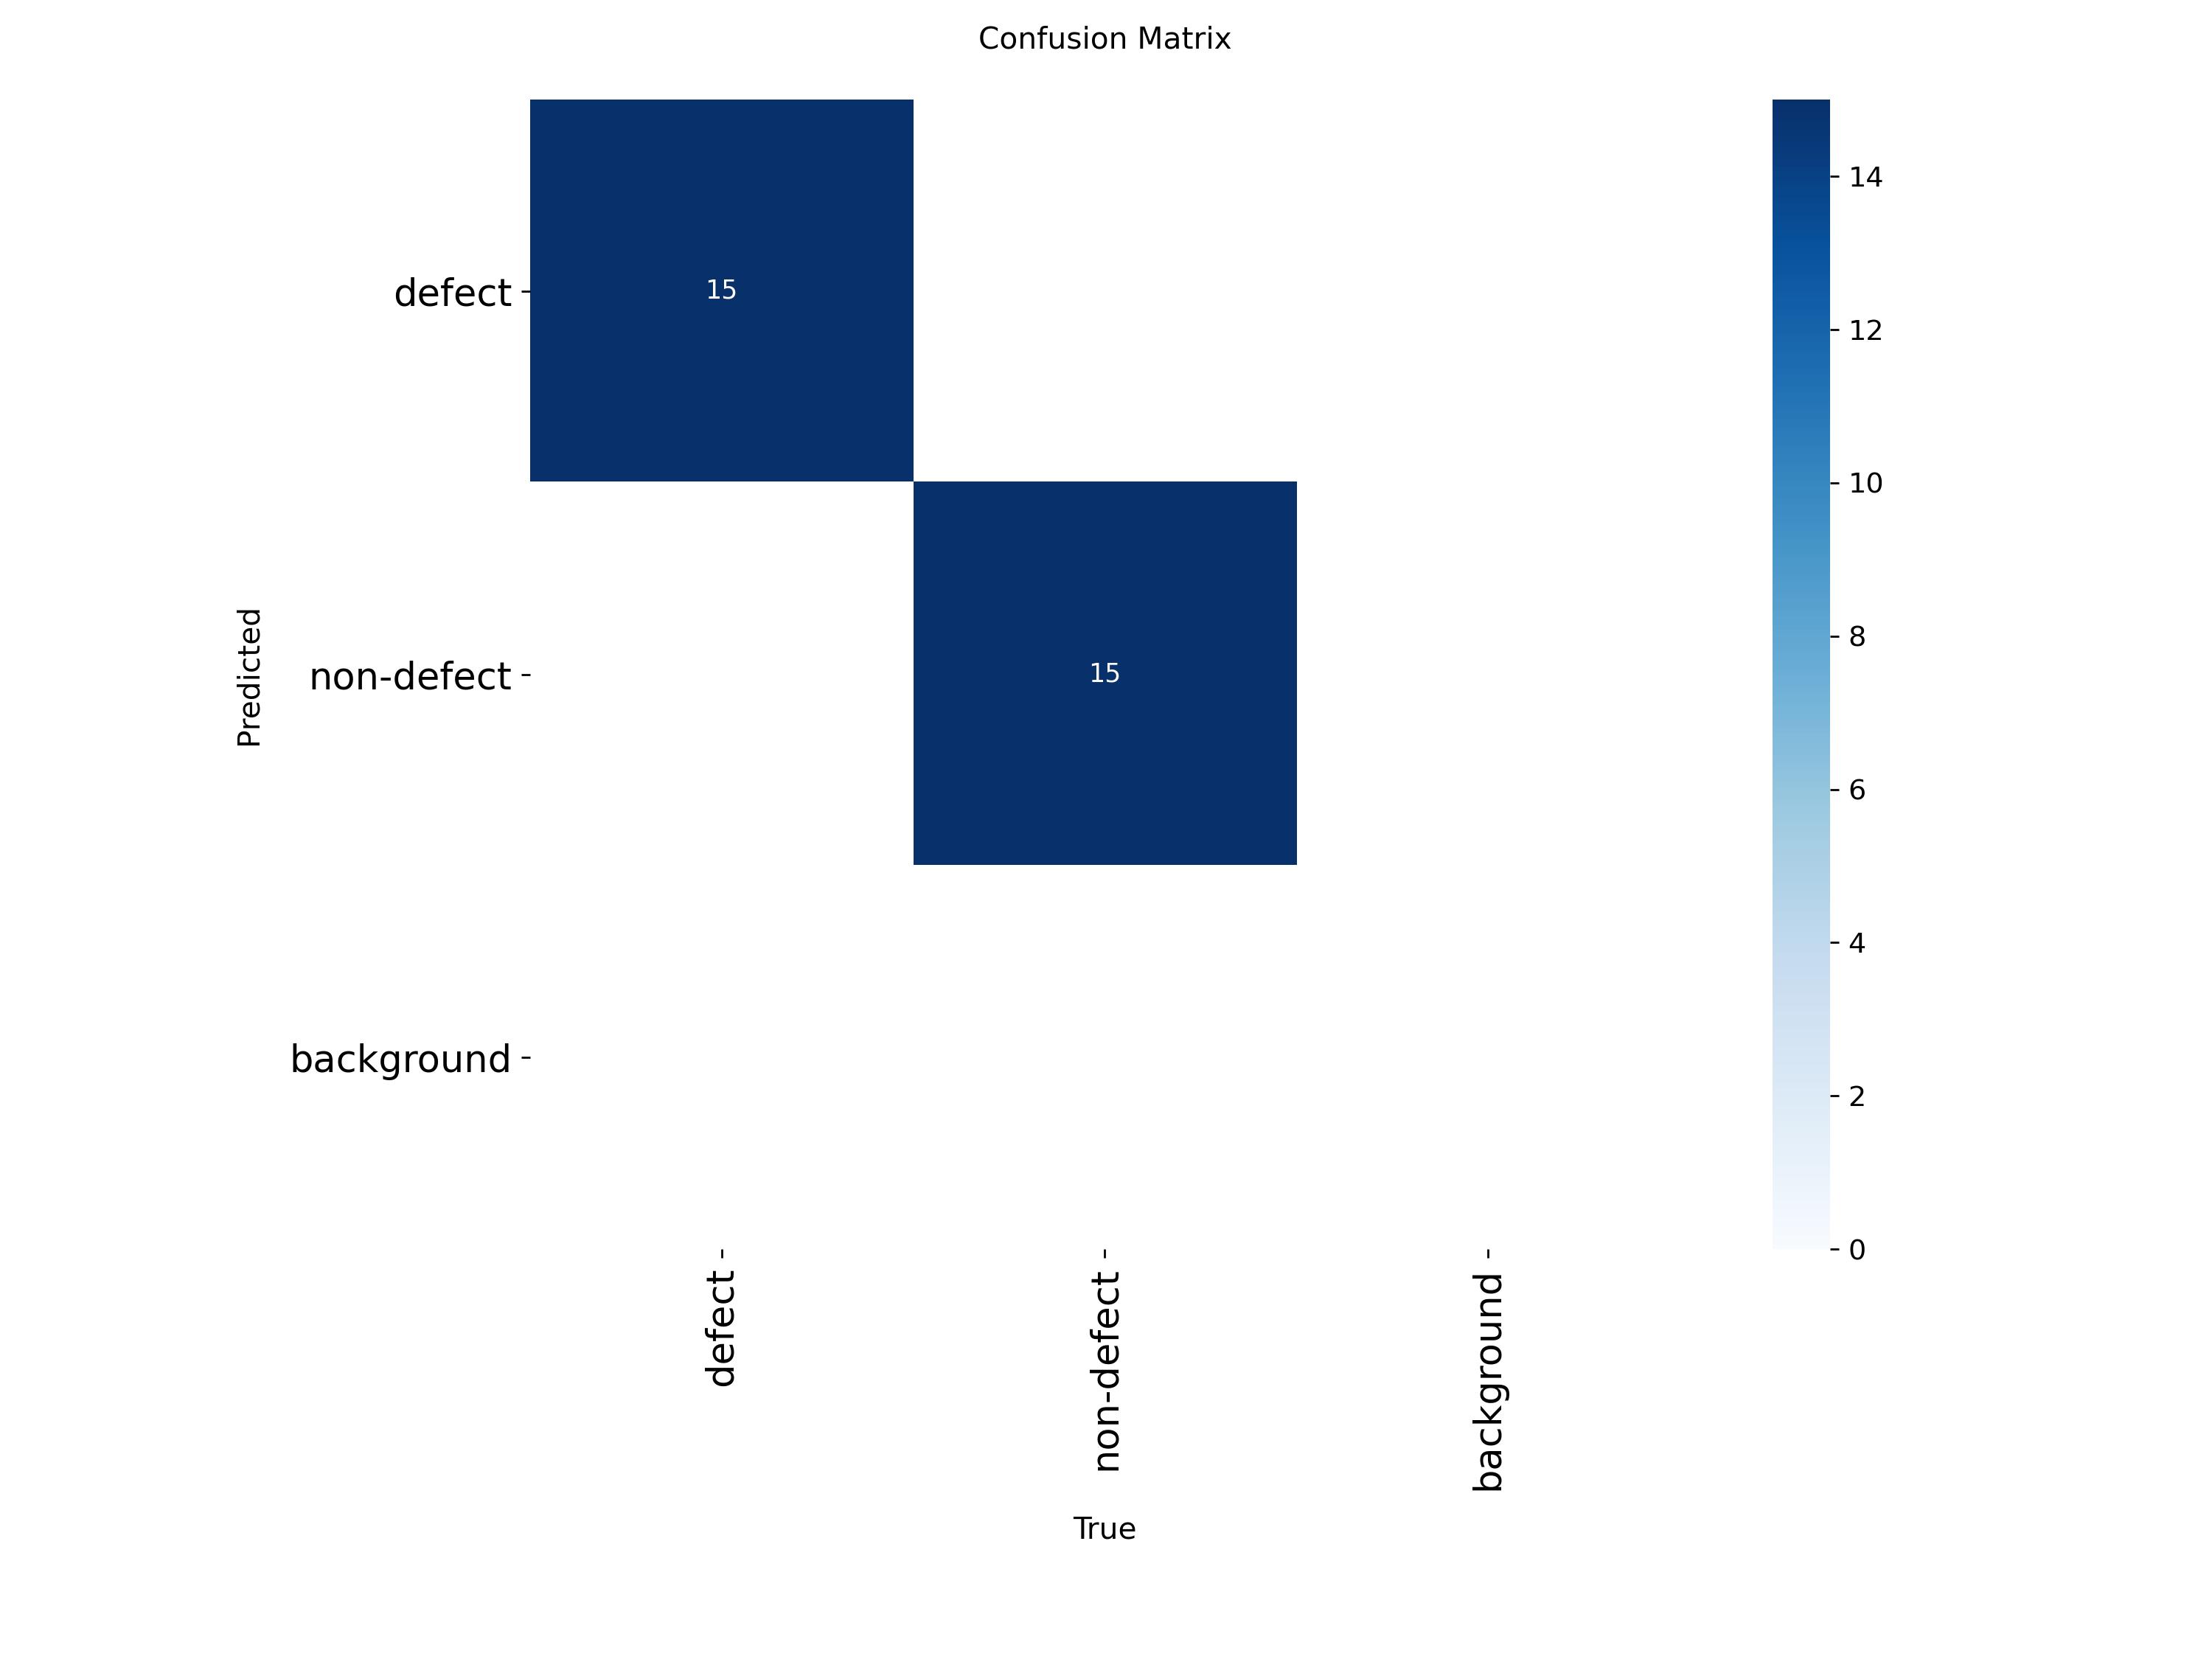

In [10]:
# ─── UNIVERSAL TRAINING-CURVE + CONFUSION-MATRIX DASHBOARD ───
import pandas as pd, numpy as np, matplotlib.pyplot as plt, glob
from pathlib import Path
from PIL import Image
from scipy.signal import savgol_filter      # tiny smoothing
plt.rcParams["figure.dpi"] = 110            # crisper in notebooks

RUN_NAME  = "bottle_defects"                # <- your run name
RUNS_DIR  = Path(RUNS_DIR)                  # re-use var from training cell
CSV_PATH  = RUNS_DIR / RUN_NAME / "results.csv"
assert CSV_PATH.exists(), f"{CSV_PATH} not found!"

# ── 1) LOAD & SELECT NUMERIC COLUMNS ──────────────────────────
df       = pd.read_csv(CSV_PATH)
numcols  = [c for c in df.columns if df[c].dtype != "O"]       # keep numeric only
epochs   = df.index

# optional custom order – put most common metrics first, others later
order_hint = [
    "train/box_loss", "train/obj_loss", "train/dfl_loss", "train/cls_loss",
    "val/box_loss",   "val/obj_loss",   "val/dfl_loss",   "val/cls_loss",
    "metrics/precision", "metrics/recall",
    "metrics/mAP_0.5", "metrics/mAP_0.5:0.95"
]
cols = [c for c in order_hint if c in numcols] + [c for c in numcols if c not in order_hint]

# ── 2) PLOT ───────────────────────────────────────────────────
rows = 2
cols_per_row = int(np.ceil(len(cols) / rows))
plt.figure(figsize=(cols_per_row * 3.5, rows * 3))

def smooth(y, window=5, poly=2):
    w = min(window if len(df) > window else len(df) | 1, len(df))
    return savgol_filter(y, w, poly) if len(y) >= w else y

for i, col in enumerate(cols, 1):
    plt.subplot(rows, cols_per_row, i)
    y = df[col].values
    plt.plot(epochs, y, label="results", lw=1.8, marker="o", ms=3)
    plt.plot(epochs, smooth(y), "r--", label="smooth", alpha=.6)
    plt.title(col, fontsize=9)
    plt.grid(lw=.3, ls=":")
    if i == 1:
        plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

# ── 3) SHOW CONFUSION-MATRIX PNG IF FOUND ─────────────────────
cm_candidates = glob.glob(str(RUNS_DIR / RUN_NAME / "confusion_matrix*.png"))
if cm_candidates:
    print("\nConfusion matrix image found ↓")
    display(Image.open(cm_candidates[0]))
else:
    print("\n(no confusion-matrix PNG found in run folder)")
